[참고(proj_2)](https://colab.research.google.com/drive/1Z_fQ3JNxnuVIcMf89Q7vGylU6dtn-zAW?usp=sharing)

# Proj: 네이버 영화 리뷰 감성 분류에 SentencePiece적용하기

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

# 순서 정리
1. 데이터 불러오기
2. 데이터 정제
    - 중복 데이터 제거, 결측치 제거, + etc...
3. 토큰화(형태소 분석기(mecab) 
    - 혹은 sentencepiece(BPE)

    3-1. sp_tokenize 함수 정의
        - 텍스트를 시퀀스로 변환
        - sentencepiece로 학습시킨 vocab 읽어오기
        - 단어장 생성
        - padding
4. x와 y 정의하기
    - x : document
    - y : label
5. x를 sp_tokenize 통과
6. validation 데이터 분리
    - train 데이터에서 분리한다
7. 모델 설계
8. 모델 학습
9. 정확도 확인
10. 그래프 그리기

## **1. 네이버 영화 리뷰 데이터 정리**

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re, os
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import tensorflow as tf

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f9750416790>)

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data.info

<bound method DataFrame.info of               id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[150000 rows x 3 columns]>

In [ ]:
test_data.info

<bound method DataFrame.info of             id                                           document  label
0      6270596                                                굳 ㅋ      1
1      9274899                               GDNTOPCLASSINTHECLUB      0
2      8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3      6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4      6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0
...        ...                                                ...    ...
49995  4608761          오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함      1
49996  5308387       의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO      0
49997  9072549                 그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다      0
49998  5802125     절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네      0
49999  6070594                                         마무리는 또 왜이래      0

[50000 rows x 3 columns]>

In [ ]:
# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
# Nan 결측치 제거
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.1 MB/s 


## **2. SentencePiece 적용(토큰화)**

In [ ]:
import sentencepiece as spm
import csv

In [ ]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz

--2022-05-19 00:28:23--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-05-19 00:28:24--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [ ]:
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


In [ ]:
# sentencepiece로 학습
spm.SentencePieceTrainer.Train('--input=korean-english-park.train.ko --model_prefix=korean_spm --vocab_size=8000 --model_type=bpe')

# model type : unigram , bpe, char, word

In [ ]:
sp = spm.SentencePieceProcessor()                                                # sp를 spm.SentencePieceProcessor()으로 객체화하여 사용한다.
vocab_file = 'korean_spm.model'
sp.load(vocab_file)

True

In [ ]:
print(sp.encode_as_pieces(train_data['document'][1]))
print(sp.encode_as_ids(train_data['document'][1]))

['▁', '흠', '...', '포', '스터', '보고', '▁초', '딩', '영화', '줄', '..', '..', '오', '버', '연', '기', '조차', '▁가', '볍', '지', '▁않', '구', '나']
[6676, 7923, 221, 6827, 530, 3406, 378, 7424, 3640, 7072, 205, 205, 6772, 6905, 6794, 6697, 6023, 24, 7807, 6685, 58, 6756, 6724]


In [ ]:
print(sp.encode_as_pieces(test_data['document'][2]))
print(sp.encode_as_ids(test_data['document'][2]))

['▁', '뭐', '야', '▁이', '▁평', '점', '들은', '..', '..', '▁나', '쁘', '진', '▁않지만', '▁10', '점', '▁', '짜', '리는', '▁더', '더', '욱', '▁아니', '잖', '아']
[6676, 7896, 6830, 3, 312, 6983, 55, 205, 205, 67, 7514, 6801, 4681, 238, 6983, 6676, 7374, 147, 135, 6879, 7350, 619, 0, 6708]


## **3. sp_tokenize() 함수 정의하기**

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))                # 텍스트 -> 시퀀스 (0517 파일)

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_to_index = {}                                   # 단어장 (딕셔너리)
    index_to_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_to_index.update({word:idx})
        index_to_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')      # 여기서 미리 패딩을 한다

    return tensor, word_to_index, index_to_word

1) 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

2) 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

3) 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

### sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

## **4. x, y 정의하기**

In [ ]:
print(train_data['document'].shape)
print(test_data['label'].shape)

(146182,)
(49157,)


In [ ]:
x_train = train_data['document']
x_test = test_data['document']

y_train = train_data['label']
y_test = test_data['label']

In [ ]:
print(x_train.shape)
print(x_test.shape)

(146182,)
(49157,)


## **5. sp_tokenize 통과**

In [ ]:
x_train_tensor, x_train_word_to_index, x_train_index_to_word = sp_tokenize(sp, x_train)
x_test_tensor, x_test_word_to_index, x_train_index_to_word = sp_tokenize(sp, x_train)

## **6. validation 분리하기**

sklearn의 train_test_split()을 사용할 수 있다

In [ ]:
x_val = x_train_tensor[:5000]
y_val = y_train[:5000]

partial_x_train = x_train_tensor[50000:]
partial_y_train = y_train[50000:]

In [ ]:
print(partial_x_train.shape)
print(partial_y_train.shape); print()

print(x_val.shape)
print(y_val.shape)

(96182, 140)
(96182,)

(5000, 140)
(5000,)


## **7. 모델 설계**

In [ ]:
vocab_size = 10000
word_vector_dim = 200                                                            # 2의 배수, 단어에 대한 차원 지정

model = keras.Sequential(name = 'LSTM')
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128, return_sequences = True))
model.add(keras.layers.Dense(64, activation = 'relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(64, return_sequences = True))
model.add(keras.layers.Dense(32, activation = 'relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(16, return_sequences = True))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         168448    
                                                                 
 dense_3 (Dense)             (None, None, 64)          8256      
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_3 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense_4 (Dense)             (None, None, 32)          2080      
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0      

## **8. 모델 학습**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
188/188 [==============================] - 16s 65ms/step - loss: 0.6197 - accuracy: 0.6590 - val_loss: 0.5449 - val_accuracy: 0.7584
Epoch 2/100
188/188 [==============================] - 11s 61ms/step - loss: 0.5713 - accuracy: 0.7095 - val_loss: 0.5055 - val_accuracy: 0.7466
Epoch 3/100
188/188 [==============================] - 11s 61ms/step - loss: 0.5013 - accuracy: 0.7827 - val_loss: 0.4863 - val_accuracy: 0.7880
Epoch 4/100
188/188 [==============================] - 11s 60ms/step - loss: 0.4589 - accuracy: 0.7979 - val_loss: 0.4547 - val_accuracy: 0.7998
Epoch 5/100
188/188 [==============================] - 11s 59ms/step - loss: 0.4527 - accuracy: 0.8002 - val_loss: 0.4747 - val_accuracy: 0.7930
Epoch 6/100
188/188 [==============================] - 11s 59ms/step - loss: 0.4183 - accuracy: 0.8179 - val_loss: 0.4269 - val_accuracy: 0.8088
Epoch 7/100
188/188 [==============================] - 11s 59ms/step - loss: 0.3804 - accuracy: 0.8349 - val_loss: 0.4160 - val_ac

return_sequences가 없는 경우 -> loss 및 val_accuracy 고정

In [ ]:
vocab_size = 10000
word_vector_dim = 200                                                            # 2의 배수, 단어에 대한 차원 지정

model = keras.Sequential(name = 'LSTM')
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(8, activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         2000000   
                                                                 
 lstm_1 (LSTM)               (None, 32)                29824     
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,030,097
Trainable params: 2,030,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs= 100
history = model.fit(partial_x_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1)

Epoch 1/100
188/188 [==============================] - 5s 18ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 2/100
188/188 [==============================] - 3s 15ms/step - loss: 0.6931 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 3/100
188/188 [==============================] - 3s 15ms/step - loss: 0.6931 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 4/100
188/188 [==============================] - 3s 16ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 5/100
188/188 [==============================] - 3s 15ms/step - loss: 0.6931 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 6/100
188/188 [==============================] - 3s 15ms/step - loss: 0.6931 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 7/100
188/188 [==============================] - 3s 15ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy:

KeyboardInterrupt: ignored

## **9. 정확도 확인하기**

In [ ]:
result = model.evaluate(x_val, y_val, verbose = 2)
print(result)

157/157 - 3s - loss: 1.1414 - accuracy: 0.7983 - 3s/epoch - 20ms/step
[1.1413824558258057, 0.7983072996139526]


## **10. 그래프 그리기**

In [ ]:
history_dict = history.history

print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

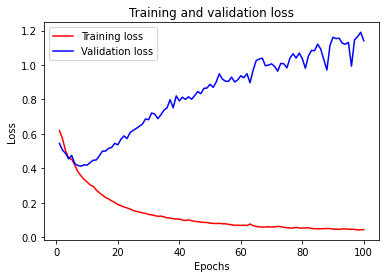

In [ ]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

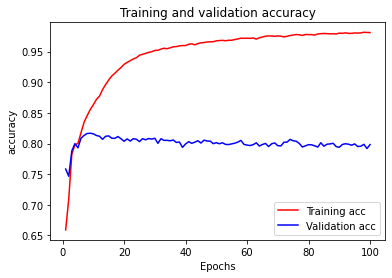

In [ ]:
plt.clf() #그림을 초기화

plt.plot(epochs, acc, 'r-', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

[첨부(예시_1)](https://drive.google.com/file/d/1uf3_GTpO0jiKCwb54NziMRd3GsoK7m_K/view?usp=sharing) [첨부(예시_2)](https://drive.google.com/file/d/1cimkCom8HVaJexkUw-aPV9PeoTcACGpY/view?usp=sharing)